In [31]:
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import os
import random
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys

sys.path.append("/home/ubuntu/workspace/Airbus_ship")
from src.dataloader.dataset import CocoDataset, get_dataloader
from src.dataloader.augmentation import (
    get_train_transforms, get_valid_transforms
)
from src.model.mask_rcnn import get_model_instance_segmentation

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [60]:
class CocoDataset(Dataset):
    def __init__(self, dataset_dir, ann_file, mode, transforms):
        ann_file = os.path.join(dataset_dir, "annotation", ann_file)
        self.imgs_dir = os.path.join(dataset_dir, mode)
        self.coco = COCO(ann_file)
        self.img_ids = self.coco.getImgIds()

        self.transforms = transforms

    def __getitem__(self, idx):
        '''
        Args:
            idx: index of sample to be fed
        return:
            dict containing:
            - PIL Image of shape (H, W)
            - target (dict) containing:
                - boxes:    FloatTensor[N, 4], N being the n° of instances and it's bounding
                boxe coordinates in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H;
                - labels:   Int64Tensor[N], class label (0 is background);
                - image_id: Int64Tensor[1], unique id for each image;
                - area:     Tensor[N], area of bbox;
                - iscrowd:  UInt8Tensor[N], True or False;
                - masks:    UInt8Tensor[N, H, W], segmantation maps;
        '''
        img_id = self.img_ids[idx]
        img_obj = self.coco.loadImgs(img_id)[0]
        anns_obj = self.coco.loadAnns(self.coco.getAnnIds(img_id))
        num_obj = len(anns_obj)

        img = Image.open(os.path.join(self.imgs_dir, img_obj['file_name']))

        # list comprhenssion is too slow, might be better changing it
        bboxes = [
            [
                ann['bbox'][0],
                ann['bbox'][1],
                ann['bbox'][0] + ann['bbox'][2],
                ann['bbox'][1] + ann['bbox'][3]
            ] for ann in anns_obj
        ]
        # bboxes = ? from [x, y, w, h] to [x0, y0, x1, y1]
        masks = [self.coco.annToMask(ann) for ann in anns_obj]
        self.masks = masks
        areas = [ann['area'] for ann in anns_obj]

        target = {}
        if self.transforms is not None:
            data = {
                "image": np.array(img),
                "mask": np.sum(np.array(masks), axis=0),
                "bboxes": bboxes,
                "labels": np.array(["ship" for _ in bboxes])
            }
            transformed = self.transforms(**data)
            img = transformed["image"]
            target["boxes"] = transformed["bboxes"]
            target["masks"] = transformed["mask"]
        else:
            target["boxes"] = bboxes
            target["masks"] = masks
        target["labels"] = torch.ones((num_obj, ), dtype=torch.int64)

        target["boxes"] = torch.as_tensor(target["boxes"], dtype=torch.float32)
        target["masks"] = torch.as_tensor(target["masks"], dtype=torch.uint8)
        target["image_id"] = torch.tensor([img_id])
        target["area"] = torch.as_tensor(areas)
        target["iscrowd"] = torch.zeros(len(anns_obj), dtype=torch.int64)

        return img, target

    def __len__(self):
        return len(self.img_ids)

In [61]:
train_aug = get_train_transforms()
val_aug = get_valid_transforms()

train_dataset = CocoDataset(
    dataset_dir="/home/ubuntu/workspace/Airbus_ship/dataset",
    ann_file="train.json",
    mode="train",
    transforms=train_aug
)

val_dataset = CocoDataset(
    dataset_dir="/home/ubuntu/workspace/Airbus_ship/dataset",
    ann_file="val.json",
    mode="val",
    transforms=val_aug
)

train_dataloader = get_dataloader(train_dataset,batch_size=1)
val_dataloader = get_dataloader(val_dataset, batch_size=1)


loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(num_classes=2)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


test output

In [62]:
image, target = next(iter(train_dataloader))

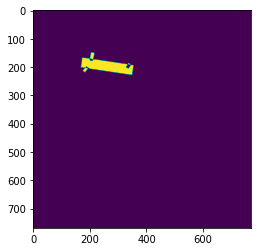

In [63]:
plt.imshow(np.sum(train_dataset.masks, axis=0, keepdims=True).transpose(1, 2, 0))

In [64]:
image = image[0]
target = target[0]

In [65]:
target["masks"].max()

tensor(1, dtype=torch.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


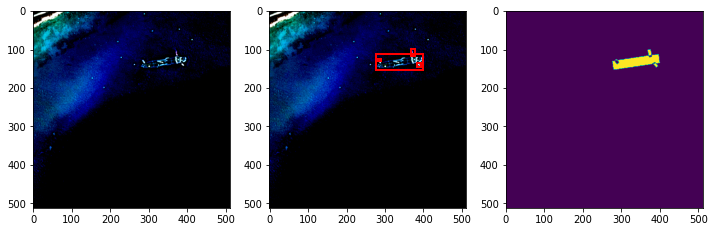

In [67]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(image.numpy().transpose(1, 2, 0))
ax2.imshow(image.numpy().transpose(1, 2, 0))
for bbox in target["boxes"]:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), 
        bbox[2] - bbox[0], 
        bbox[3] - bbox[1],
        linewidth = 2,
        edgecolor="red",
        facecolor=None,
        fill=False
    )
    ax2.add_patch(rect)

ax3.imshow(target["masks"].numpy())

Model creation

In [7]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [8]:
model = get_model_instance_segmentation(num_classes=2)
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

test forward()

In [9]:
def collate_fn(batch):
    images, labels = tuple(zip(*batch))
    labels = [{k: v for k, v in t.items()} for t in labels]
    return [images, labels]

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

model.to("cpu")
images, targets = next(iter(data_loader))
print(images[0].shape)
print(targets[0]["masks"].shape)

# targets["boxes"] = targets["boxes"][0]
# targets["labels"] = targets["labels"][0]
output = model(images, targets)
output

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


{'loss_classifier': tensor(0.3971, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1685, grad_fn=<DivBackward0>),
 'loss_mask': tensor(1.6748, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.9982, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.8334, grad_fn=<DivBackward0>)}

In [10]:
train_dataloader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=3,
    collate_fn=collate_fn
)

In [11]:
EPOCHS = 5
clipping_value = 5
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.train()
model.to(device)

for epoch in range(EPOCHS):

    for i, batch in enumerate(train_dataloader):
        images, targets = batch
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
        optimizer.step()
 
        if (i + 1) % 10 == 0:
          print(f"epoch #{epoch + 1} Iteration #{i + 1} loss: {loss_value}")  

epoch #1 Iteration #10 loss: 3.2262635231018066
epoch #1 Iteration #20 loss: 1.735795497894287
epoch #1 Iteration #30 loss: 1.5866228342056274
epoch #1 Iteration #40 loss: 1.5275273323059082
epoch #1 Iteration #50 loss: 2.0880796909332275
epoch #1 Iteration #60 loss: 0.8876438736915588
epoch #1 Iteration #70 loss: 1.2022068500518799
epoch #1 Iteration #80 loss: 1.1849219799041748
epoch #1 Iteration #90 loss: 2.2549960613250732
epoch #1 Iteration #100 loss: 0.9271563291549683
epoch #1 Iteration #110 loss: 1.1246142387390137
epoch #1 Iteration #120 loss: 1.4649817943572998
epoch #1 Iteration #130 loss: 1.0425662994384766
epoch #1 Iteration #140 loss: 1.8789981603622437
epoch #1 Iteration #150 loss: 0.8776026368141174
epoch #1 Iteration #160 loss: 1.359560251235962
epoch #1 Iteration #170 loss: 1.1230894327163696
epoch #1 Iteration #180 loss: 1.0274839401245117
epoch #1 Iteration #190 loss: 1.6491461992263794
epoch #1 Iteration #200 loss: 1.6314677000045776
epoch #1 Iteration #210 loss: 1

KeyboardInterrupt: 

In [12]:
torch.save(model, "/workspace/output/weight_7560.pth")

Inference

In [37]:
model.eval()
images, targets = next(iter(train_dataloader))
images = list(image.to(device) for image in images)
output = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


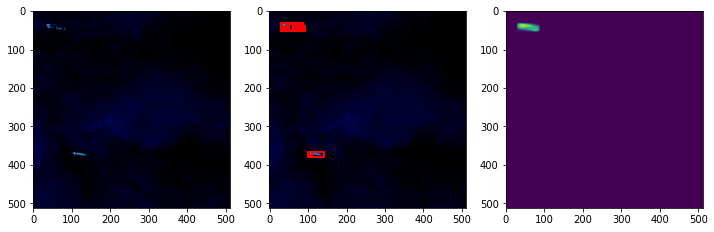

In [38]:
idx = 0

image = images[idx].to("cpu").numpy().transpose(1, 2, 0)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(image)
ax2.imshow(image)
for bbox in output[idx]["boxes"].to("cpu").detach().numpy():
    if max(bbox) > 512 or min(bbox) < 0:
        continue
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), 
        bbox[2] - bbox[0], 
        bbox[3] - bbox[1],
        linewidth = 2,
        edgecolor="red",
        facecolor=None,
        fill=False
    )
    ax2.add_patch(rect)

ax3.imshow(output[0]["masks"][0].to("cpu").detach().numpy().transpose(1, 2, 0))